In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = 0, it's a 'non-cat' picture.


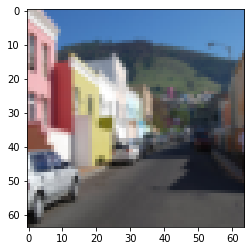

In [4]:
# Example of a picture
index =1
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

# Inspecting matrix dimensions

In [5]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [6]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = [[[196 192 190]
  [193 186 182]
  [188 179 174]
  ...
  [ 90 142 200]
  [ 90 142 201]
  [ 90 142 201]]

 [[230 229 229]
  [204 199 197]
  [193 186 181]
  ...
  [ 91 143 201]
  [ 91 143 201]
  [ 91 143 201]]

 [[232 225 224]
  [235 234 234]
  [208 205 202]
  ...
  [ 91 144 202]
  [ 91 144 202]
  [ 92 144 202]]

 ...

 [[ 18  17  15]
  [ 14  14  13]
  [ 29  29  32]
  ...
  [ 83  81  81]
  [ 84  82  83]
  [ 82  81  82]]

 [[ 22  20  18]
  [ 16  15  14]
  [ 25  24  24]
  ...
  [ 82  80  80]
  [ 83  81  82]
  [ 82  81  81]]

 [[ 45  43  39]
  [ 61  59  54]
  [ 81  78  74]
  ...
  [ 83  82  81]
  [ 84  82  82]
  [ 82  80  81]]]
Each image is of size: ([[[196 192 190]
  [193 186 182]
  [188 179 174]
  ...
  [ 90 142 200]
  [ 90 142 201]
  [ 90 142 201]]

 [[230 229 229]
  [204 199 197]
  [193 186 181]
  ...
  [ 91 143 201]
  [ 91 143 201]
  [ 91 143 201]]

 [[232 225 224]
  

# Flattening the images to feed the network
We want to reshape the image of shape (width, height, color channel) to (width * height * color channel, 1 ) which is basically a vector with one column

In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


## Standardizing data

In [8]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

# Building the Neural Network

In [9]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

## Initializing parameters

In [10]:
def initialize_with_zeros(dim):
  """
  This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
  
  Argument:
  dim -- size of the w vector we want (or number of parameters in this case)
  
  Returns:
  w -- initialized vector of shape (dim, 1)
  b -- initialized scalar (corresponds to the bias)
  """
  w = np.zeros((dim, 1))
  b = 0

  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))
  return w, b

In [11]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [29]:
def propagate(w, b, X, Y):
  """
  Implement the cost function and its gradient for the propagation explained above

  Arguments:
  w -- weights, a numpy array of size (num_px * num_px * 3, 1)
  b -- bias, a scalar
  X -- data of size (num_px * num_px * 3, number of examples)
  Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

  Return:
  cost -- negative log-likelihood cost for logistic regression
  dw -- gradient of the loss with respect to w, thus same shape as w
  db -- gradient of the loss with respect to b, thus same shape as b
  
  Tips:
  - Write your code step by step for the propagation. np.log(), np.dot()
  """
  m = X.shape[1]
  # forward propagation
  z= w.T.dot(X)+b
  A = sigmoid(z)
  J = np.sum(Y*np.log(A)+(1-Y)*np.log((1-A)))
  cost = -J/m

  #Backpropagation
  dz = A - Y
  dw = np.dot(X, dz.T)/m
  db = np.sum(dz)/m

  assert(dw.shape == w.shape)
  assert(db.dtype == float)
  cost = np.squeeze(cost)
  assert(cost.shape == ())
  
  grads = {"dw": dw,
            "db": db}
    
  return grads, cost



In [30]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553
